## 1. Import and Setup

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning (you will probably need to add more)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, mean_squared_error

## 2. Load the Data

In [5]:
df=bike_sharing_demand_df = pd.read_csv('bike-sharing-demand.csv')

## 3. Feature Engineering - Time
📅 Temporal Analysis:

By Hour: Clear commuter peaks around 8 AM and 5-6 PM.

By Weekday: Higher usage on working days, with slight drops on weekends.

By Month: Seasonal variations visible, with warmer months showing more activity.

By Season: Spring and summer typically have higher rental volumes.

By Year: Demand increased in the second year of data.


Target: Count
Features: .....
Derivative features: 

In [14]:
# Convert 'datetime' column to datetime type explicitly
df["datetime"] = pd.to_datetime(df["datetime"])

# Feature engineering
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday
df["month"] = df["datetime"].dt.month
df["year"] = df["datetime"].dt.year
df["weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)
df["holiday"] = df["holiday"]
df["workingday"] = df["workingday"]



In [49]:
# Function for boxplot visualizations
def plot_box_by_feature(data, feature, title):
    """
    Plot boxplot of bike rental count grouped by a specified categorical feature.
    
    Parameters:
    data (DataFrame): Dataset containing bike rental data.
    feature (str): Feature to group by.
    title (str): Plot title.
    """
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=feature, y="count", data=data)
    plt.title(title)
    plt.xlabel(feature.capitalize())
    plt.ylabel("Bike Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

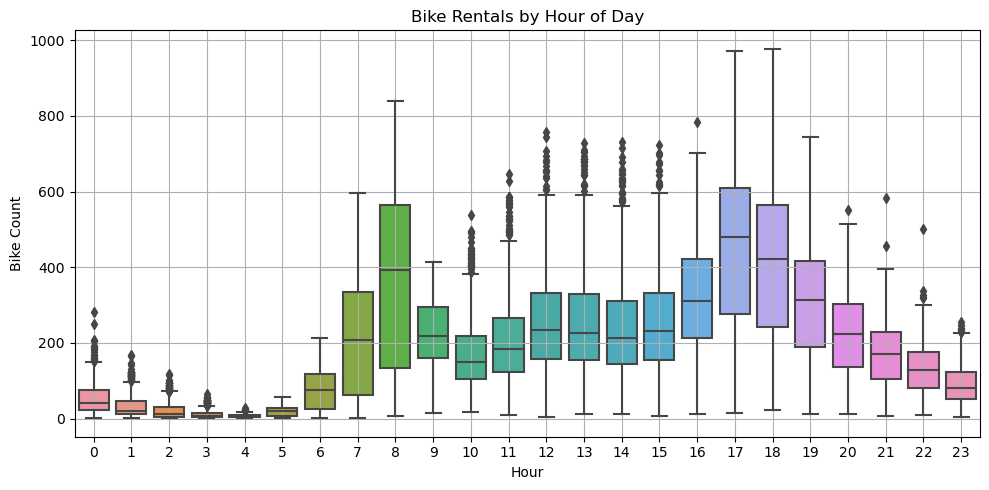

In [48]:
plot_box_by_feature(df, "hour", "Bike Rentals by Hour of Day")

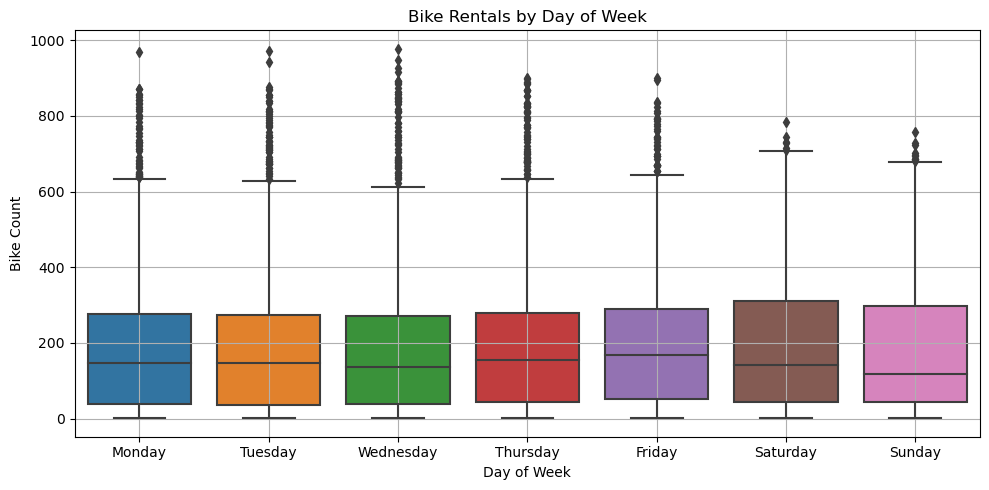

In [10]:
# Map numeric weekdays to actual weekday names
weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df["weekday_name"] = df["weekday"].map(weekday_map)

# Recreate the boxplot using weekday names
plt.figure(figsize=(10, 5))
sns.boxplot(x="weekday_name", y="count", data=df, order=list(weekday_map.values()))
plt.title("Bike Rentals by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Bike Count")
plt.grid(True)
plt.tight_layout()
plt.show()

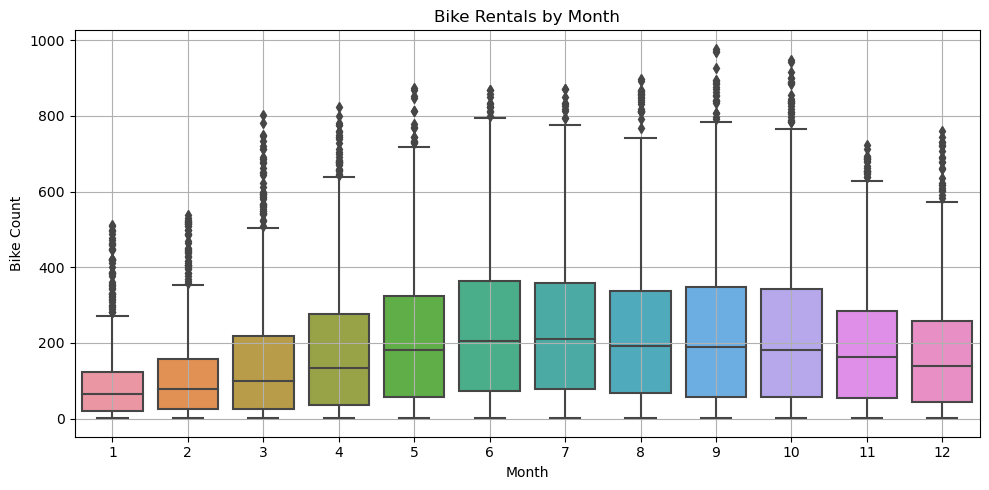

In [17]:
plot_box_by_feature(df, "month", "Bike Rentals by Month")

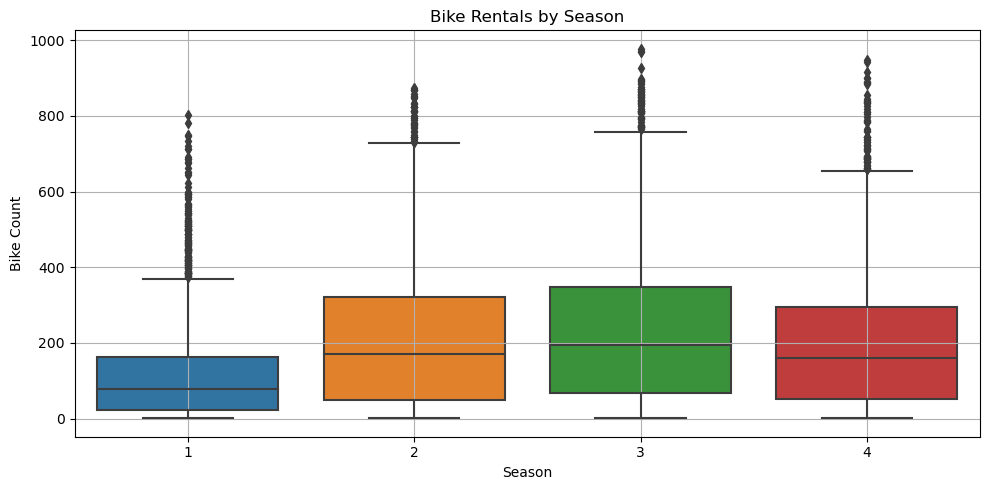

In [18]:
plot_box_by_feature(df, "season", "Bike Rentals by Season")

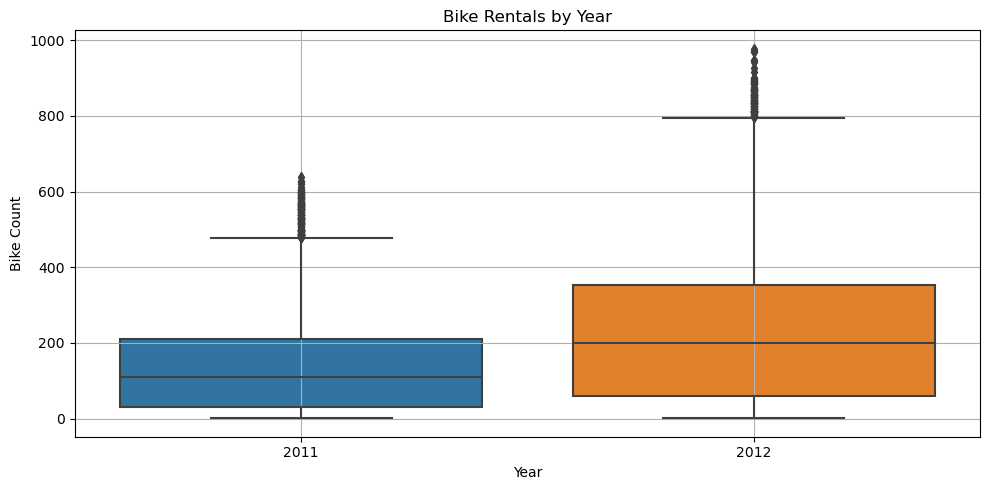

In [19]:
plot_box_by_feature(df, "year", "Bike Rentals by Year")

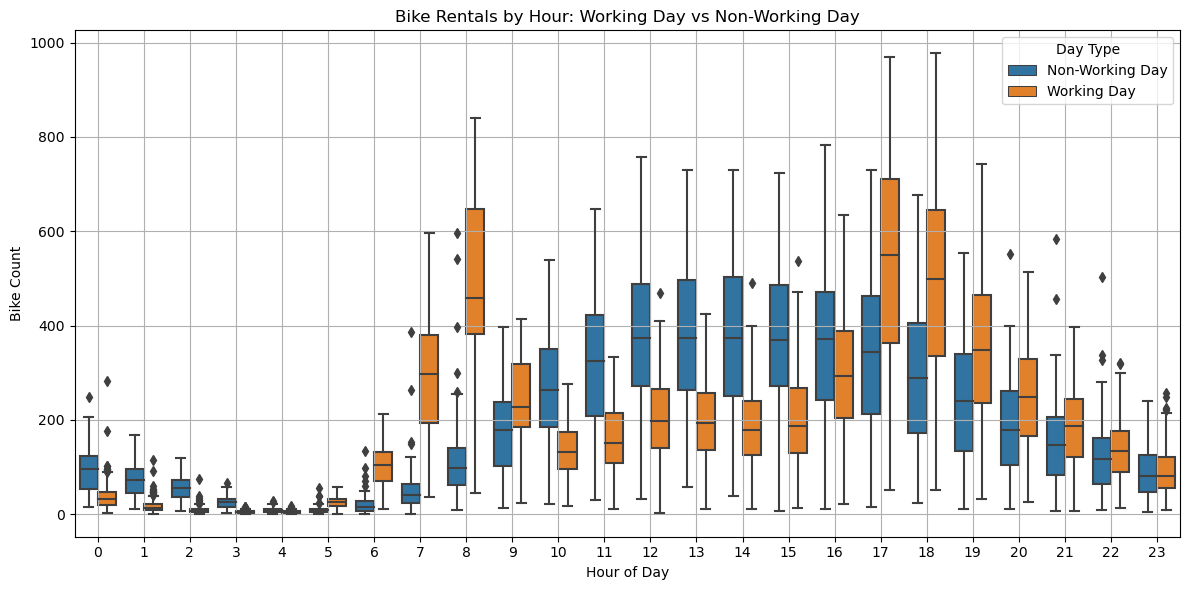

In [50]:
# Plot hour of day split by working day vs holiday
df['workingday_label'] = df['workingday'].map({0: "Non-Working Day", 1: "Working Day"})

plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="count", hue="workingday_label", data=df)
plt.title("Bike Rentals by Hour: Working Day vs Non-Working Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bike Count")
plt.legend(title="Day Type")
plt.grid(True)
plt.tight_layout()
plt.show()

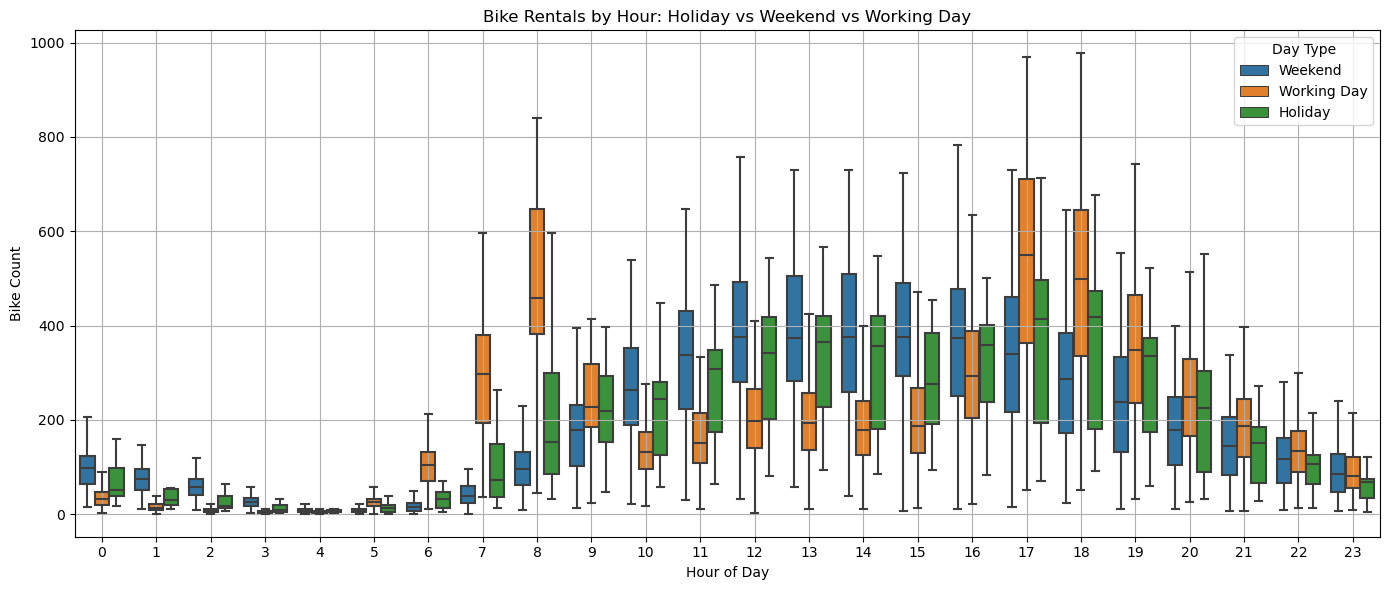

In [47]:
# Create 'day_type' column
def classify_day(row):
    if row['holiday'] == 1:
        return "Holiday"
    elif row['workingday'] == 0:
        return "Weekend"
    else:
        return "Working Day"

df['day_type'] = df.apply(classify_day, axis=1)

# Plot with hue by day type
plt.figure(figsize=(14, 6))
sns.boxplot(x="hour", y="count", hue="day_type", data=df, showfliers=False)
plt.title("Bike Rentals by Hour: Holiday vs Weekend vs Working Day")
plt.xlabel("Hour of Day")
plt.ylabel("Bike Count")
plt.legend(title="Day Type")
plt.grid(True)
plt.tight_layout()
plt.show()


## 4. Training

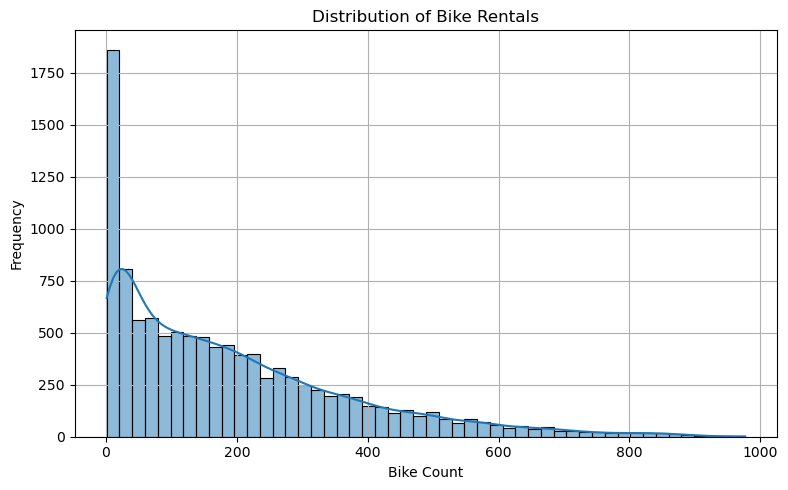

In [16]:
# Plot distribution of bike rentals
plt.figure(figsize=(8, 5))
sns.histplot(df["count"], bins=50, kde=True)
plt.title("Distribution of Bike Rentals")
plt.xlabel("Bike Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
features = ["hour", "weekday", "month", "season", "year"]
X = df[features]
y = df["count"]
#y = np.log1p(df["count"])  # log-transform the target

# First split into train and temp (70% train, 30% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Then split temp into validation and test (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Output the sizes
{
    "Train set size": len(X_train),
    "Validation set size": len(X_val),
    "Test set size": len(X_test)
}

{'Train set size': 7620, 'Validation set size': 1633, 'Test set size': 1633}

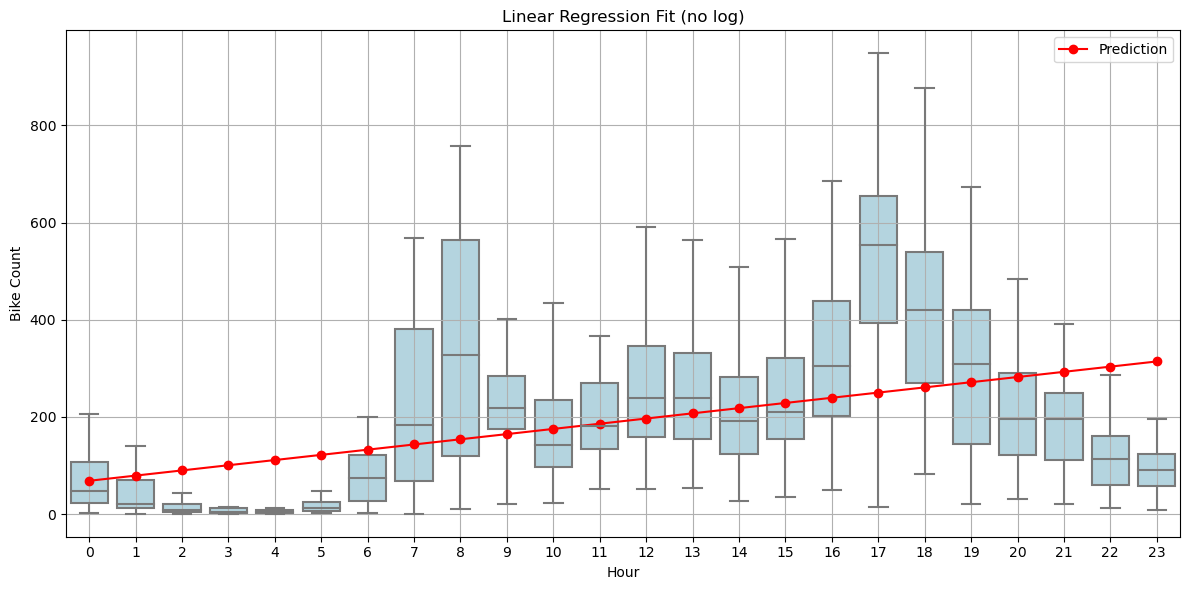

Slope (coefficient): 10.675
Intercept: 68.677
RMSE: 169.45250357202775


In [79]:
from sklearn.linear_model import LinearRegression

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metriche
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Plot boxplot + linea
df_plot = X_test.copy()
df_plot["hour"] = X_test["hour"]
df_plot["y_true"] = y_test.values
df_plot["y_pred"] = y_pred
mean_pred = df_plot.groupby("hour")["y_pred"].mean()

plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="y_true", data=df_plot, color="lightblue", showfliers=False)
plt.plot(mean_pred.index, mean_pred.values, color="red", marker="o", label="Prediction")
plt.title("Linear Regression Fit")
plt.xlabel("Hour")
plt.ylabel("Bike Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Coefficienti
slope = model.coef_[0]
intercept = model.intercept_
print(f"Slope (coefficient): {slope:.3f}")
print(f"Intercept: {intercept:.3f}")
print("RMSE:", rmse)




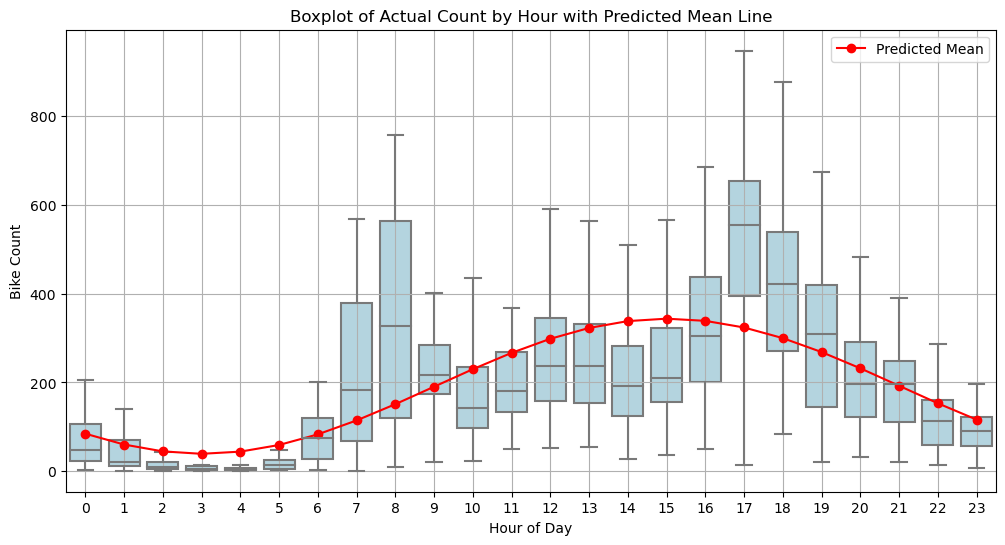

RMSE: 169.45250357202775


In [83]:
# Define periodic features
df['sin_2pi_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_2pi_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Define feature matrix and target
X = df[['sin_2pi_hour', 'cos_2pi_hour']]
y = df['count']

# Train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Fit linear regression model to periodic function
model_periodic = LinearRegression()
model_periodic.fit(X_train, y_train)

# Predict on test set
y_pred = model_periodic.predict(X_test)

# RMSE of the periodic model
rmse_periodic = mean_squared_error(y_test, y_pred, squared=False)
rmse_periodic


# Prepare a DataFrame for plotting
plot_df = X_test.copy()
plot_df['hour'] = df.loc[X_test.index, 'hour']
plot_df['y_test'] = y_test.values
plot_df['y_pred'] = y_pred

# Sort by hour for line plot
pred_mean_by_hour = plot_df.groupby('hour')['y_pred'].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Boxplot for actual values
sns.boxplot(x='hour', y='y_test', data=plot_df, color='lightblue', showfliers=False)

# Line plot for predicted mean values
plt.plot(pred_mean_by_hour.index, pred_mean_by_hour.values, color='red', marker='o', label='Predicted Mean')

plt.title("Boxplot of Actual Count by Hour with Predicted Mean Line")
plt.xlabel("Hour of Day")
plt.ylabel("Bike Count")
plt.legend()
plt.grid(True)
plt.show()
print("RMSE:", rmse)


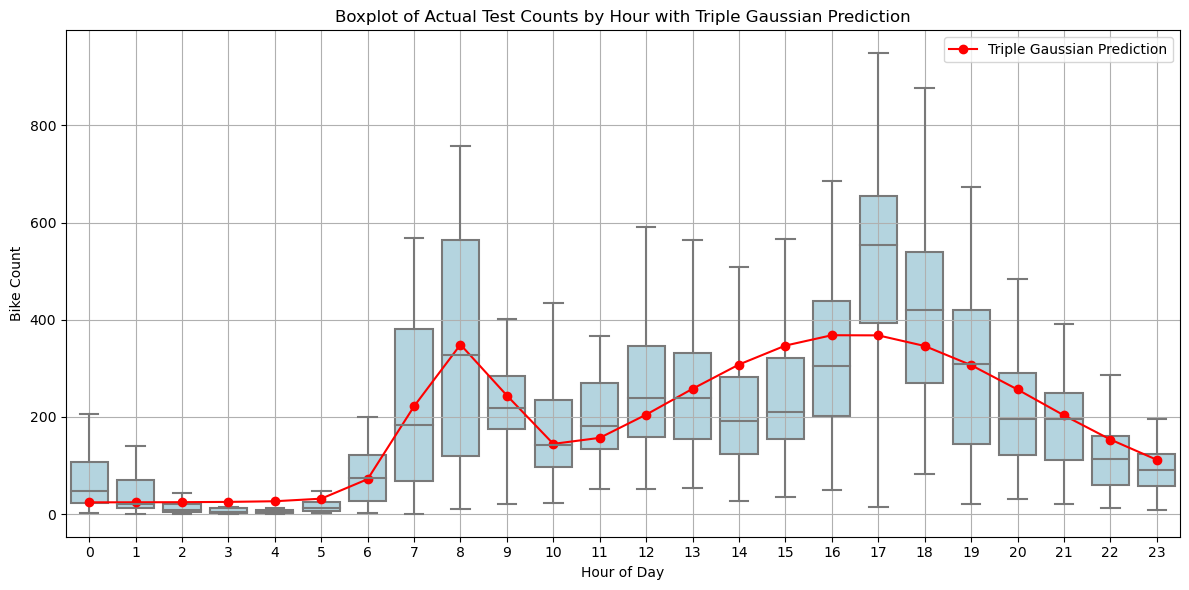


Fitted parameters:
A1: 257.533
mu1: 7.887
sigma1: 0.756
A2: 218.835
mu2: 17.611
sigma2: 0.995
A3: 263.518
mu3: 15.479
sigma3: 5.242
c: 12.584

RMSE on test set: 131.354


In [85]:
from scipy.optimize import curve_fit

# Define triple Gaussian function
def triple_gaussian(hour, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, c):
    """
    Triple Gaussian model for three peak patterns.

    Returns:
    - predicted count values
    """
    gauss1 = A1 * np.exp(-((hour - mu1)**2) / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-((hour - mu2)**2) / (2 * sigma2**2))
    gauss3 = A3 * np.exp(-((hour - mu3)**2) / (2 * sigma3**2))
    return gauss1 + gauss2 + gauss3 + c

# Use average actual count per hour to fit model
hourly_avg = df.groupby('hour')['count'].mean()
hours = hourly_avg.index.to_numpy()
counts = hourly_avg.values

# Initial guesses
initial_guess = [400, 8, 2, 500, 18, 2, 200, 12, 5, 20]

# Fit model
params, cov = curve_fit(triple_gaussian, hours, counts, p0=initial_guess)

# Predict for smooth curve
hour_grid = np.linspace(0, 23, 100)
fitted_values = triple_gaussian(hour_grid, *params)

# Prepare test set
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
X = df[['hour']]
y = df['count']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Predict on test set
X_test_with_hour = X_test.copy()
X_test_with_hour['y_test'] = y_test.values
X_test_with_hour['y_pred'] = triple_gaussian(X_test_with_hour['hour'], *params)

# Compute RMSE
rmse = mean_squared_error(X_test_with_hour['y_test'], X_test_with_hour['y_pred'], squared=False)

# Plot boxplot + prediction line
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='y_test', data=X_test_with_hour, color='lightblue', showfliers=False)
plt.plot(pred_mean_by_hour.index, pred_mean_by_hour.values, color='red', marker='o', label='Triple Gaussian Prediction')
plt.title("Boxplot of Actual Test Counts by Hour with Triple Gaussian Prediction")
plt.xlabel("Hour of Day")
plt.ylabel("Bike Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print parameters
param_names = ["A1", "mu1", "sigma1", "A2", "mu2", "sigma2", "A3", "mu3", "sigma3", "c"]
print("\nFitted parameters:")
for name, value in zip(param_names, params):
    print(f"{name}: {value:.3f}")

# Print RMSE
print(f"\nRMSE on test set: {rmse:.3f}")


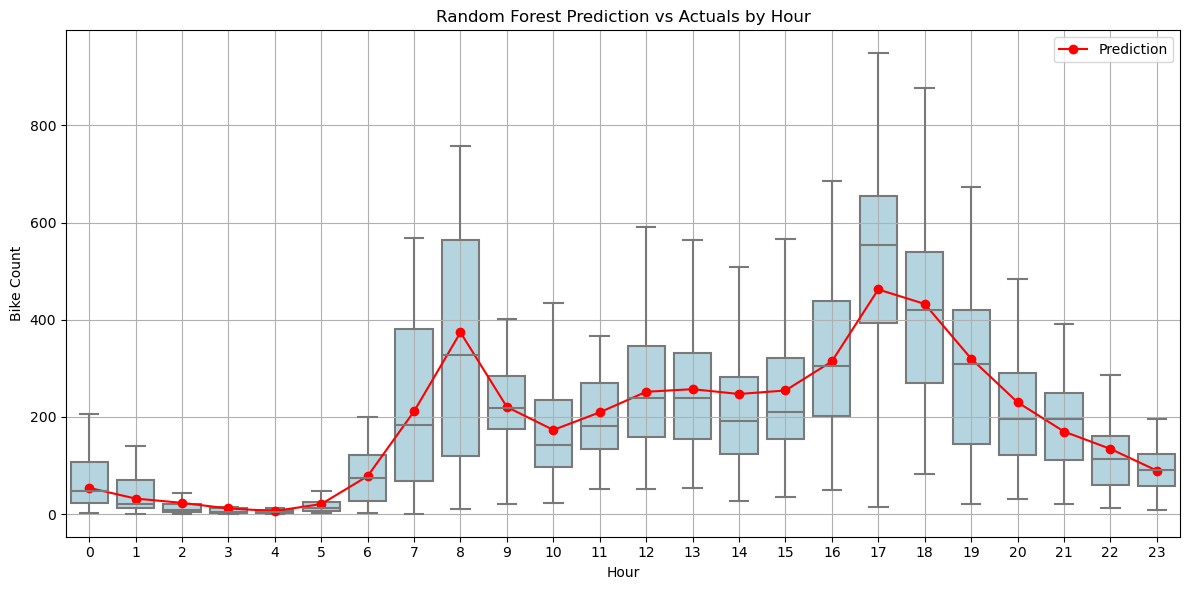

{'n_estimators': 100,
 'max_depth': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'RMSE': 129.6495635473053}

In [86]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Prepare data for boxplot and prediction line
df_plot = X_test.copy()
df_plot["hour"] = X_test["hour"]
df_plot["y_true"] = y_test.values
df_plot["y_pred"] = y_pred
mean_pred_by_hour = df_plot.groupby("hour")["y_pred"].mean()

# Boxplot with red prediction line
plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="y_true", data=df_plot, color="lightblue", showfliers=False)
plt.plot(mean_pred_by_hour.index, mean_pred_by_hour.values, color="red", marker="o", label="Prediction")
plt.title("Random Forest Prediction vs Actuals by Hour")
plt.xlabel("Hour")
plt.ylabel("Bike Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Print selected model parameters and RMSE
rf_params = rf.get_params()
rf_params_filtered = {k: rf_params[k] for k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']}
rf_params_filtered["RMSE"] = rmse
rf_params_filtered


In [87]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


# Define regression models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

def evaluate_models(X, y, log_transform=False):
    """
    Train and evaluate multiple regression models using cross-validation.
    Optionally applies log transformation to the target variable.
    
    Parameters:
    X (DataFrame): Feature data
    y (Series): Target data
    log_transform (bool): Whether to apply log1p to the target
    
    Returns:
    dict: Model names with average RMSLE or RMSE
    """
    if log_transform:
        y = np.log1p(y)
    
    results = {}
    for name, model in models.items():
        pipeline = Pipeline([
            ('preprocess', ColumnTransformer([
                ('hour_encoder', OneHotEncoder(handle_unknown='ignore'), ['hour'])
            ], remainder='passthrough')),
            ('regressor', model)
        ])
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        if log_transform:
            # Use MSE since we log-transform the target
            scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
            scores = np.sqrt(-scores)  # RMSE
        else:
            # Use RMSLE if no transformation is applied
            def rmsle_scorer(estimator, X_fold, y_fold):
                pred = estimator.predict(X_fold)
                pred = np.maximum(pred, 0)
                return -mean_squared_log_error(y_fold, pred) ** 0.5
            scores = cross_val_score(pipeline, X, y, cv=kf, scoring=rmsle_scorer)
            scores = -scores  # convert back to positive RMSLE
        results[name] = scores.mean()
    return results

# 3. Evaluate models without log1p
results_no_log = evaluate_models(X_train, y_train, log_transform=False)

# 4. Evaluate models with log1p
results_log = evaluate_models(X_train, y_train, log_transform=True)

results_no_log, results_log


({'LinearRegression': 0.80249323420296, 'RandomForest': 0.8024736665965877},
 {'LinearRegression': 0.757978304601788, 'RandomForest': 0.7580115973292105})

## Prediction

In [75]:
def predict_hour_from_user(model, X_test, y_pred):
    """
    Ask the user to input an hour and print predicted bike rentals
    for all test samples corresponding to that hour.

    Parameters:
    - model: trained RandomForestRegressor (not used directly)
    - X_test: DataFrame of test features
    - y_pred: model predictions corresponding to X_test
    """
    try:
        hour = int(input("Enter the hour of the day (0–23): ").strip())
        if not (0 <= hour <= 23):
            print("Hour must be between 0 and 23.")
            return

        results = X_test.copy()
        results["predicted_count"] = y_pred
        matches = results[results["hour"] == hour]

        if matches.empty:
            print(f"No test samples found for hour {hour}.")
        else:
            print(f"Predicted bike rental counts for hour {hour}:")
            print(matches["predicted_count"].astype(int).values)

    except ValueError:
        print("Invalid input. Please enter a valid integer between 0 and 23.")


In [80]:
predict_hour_from_user(rf, X_test, y_pred)

Enter the hour of the day (0–23): 1
Predicted bike rental counts for hour 1:
[79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79
 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79
 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79
 79 79 79 79]


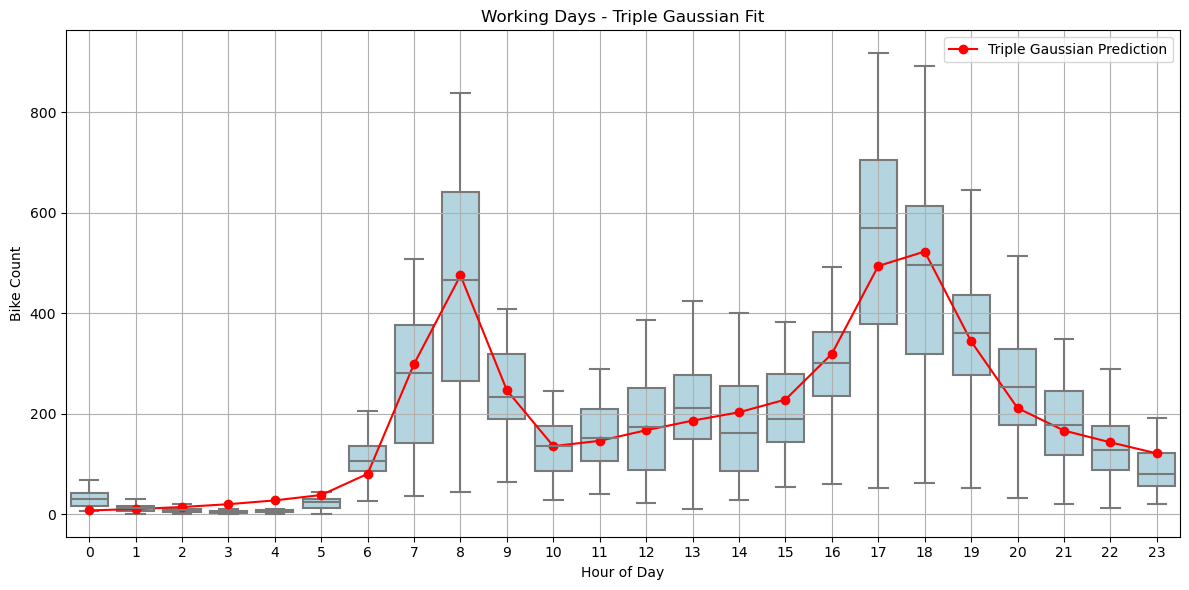


Fitted parameters for Working Days:
A1: 400.197
mu1: 7.840
sigma1: 0.811
A2: 329.853
mu2: 17.635
sigma2: 1.060
A3: 216.558
mu3: 16.433
sigma3: 5.979
c: 2.543
RMSE on Working Days test set: 109.983


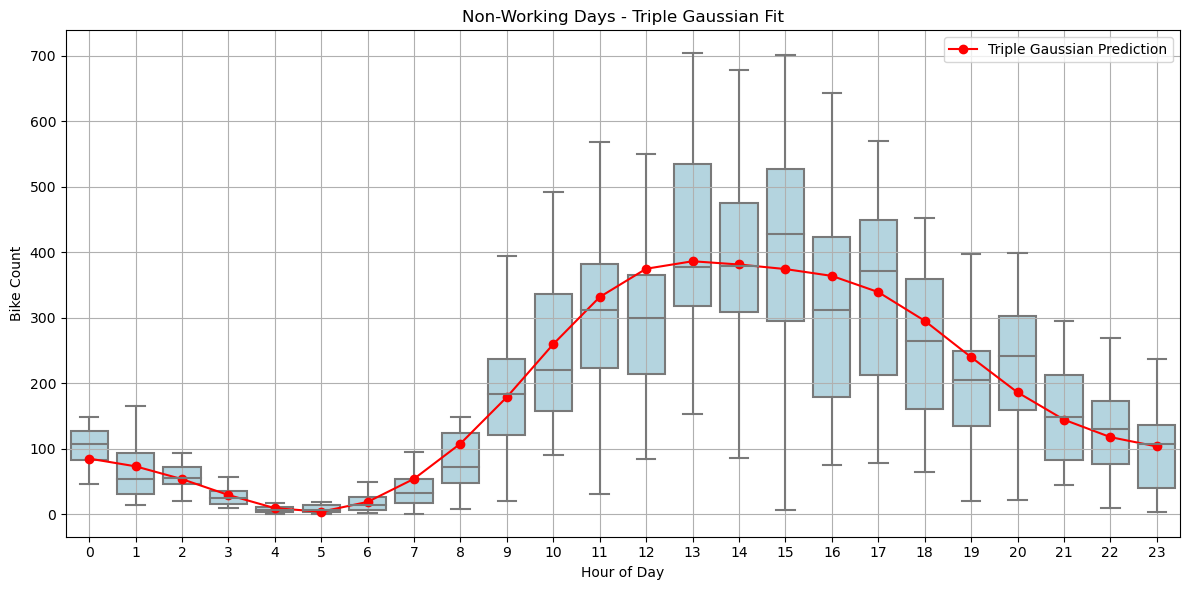


Fitted parameters for Non-Working Days:
A1: -91.093
mu1: 4.877
sigma1: 2.234
A2: 245.748
mu2: 16.287
sigma2: 2.658
A3: 217.660
mu3: 11.680
sigma3: -2.101
c: 93.551
RMSE on Non-Working Days test set: 105.630


In [89]:

# Define triple Gaussian function
def triple_gaussian(hour, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, c):
    gauss1 = A1 * np.exp(-((hour - mu1)**2) / (2 * sigma1**2))
    gauss2 = A2 * np.exp(-((hour - mu2)**2) / (2 * sigma2**2))
    gauss3 = A3 * np.exp(-((hour - mu3)**2) / (2 * sigma3**2))
    return gauss1 + gauss2 + gauss3 + c

# Initial guess and parameter names
initial_guess = [400, 8, 2, 500, 18, 2, 200, 12, 5, 20]
param_names = ["A1", "mu1", "sigma1", "A2", "mu2", "sigma2", "A3", "mu3", "sigma3", "c"]

# Function to perform fit and plot
def fit_and_plot_gaussian(df_subset, label):
    hourly_avg = df_subset.groupby('hour')['count'].mean()
    hours = hourly_avg.index.to_numpy()
    counts = hourly_avg.values

    # Fit the model
    params, _ = curve_fit(triple_gaussian, hours, counts, p0=initial_guess)

    # Split test set
    X = df_subset[['hour']]
    y = df_subset['count']
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    # Predict
    X_test_with_hour = X_test.copy()
    X_test_with_hour['y_test'] = y_test.values
    X_test_with_hour['y_pred'] = triple_gaussian(X_test_with_hour['hour'], *params)

    # Calculate RMSE
    rmse = mean_squared_error(X_test_with_hour['y_test'], X_test_with_hour['y_pred'], squared=False)

    # Plot
    pred_mean_by_hour = X_test_with_hour.groupby('hour')['y_pred'].mean()
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='hour', y='y_test', data=X_test_with_hour, color='lightblue', showfliers=False)
    plt.plot(pred_mean_by_hour.index, pred_mean_by_hour.values, color='red', marker='o', label='Triple Gaussian Prediction')
    plt.title(f"{label} - Triple Gaussian Fit")
    plt.xlabel("Hour of Day")
    plt.ylabel("Bike Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print parameters and RMSE
    print(f"\nFitted parameters for {label}:")
    for name, value in zip(param_names, params):
        print(f"{name}: {value:.3f}")
    print(f"RMSE on {label} test set: {rmse:.3f}")

# Prepare data
df["workingday"] = df["workingday"]
df["count"] = df["count"]
df_working = df[df["workingday"] == 1]
df_non_working = df[df["workingday"] == 0]

# Apply function to both subsets
fit_and_plot_gaussian(df_working, "Working Days")
fit_and_plot_gaussian(df_non_working, "Non-Working Days")


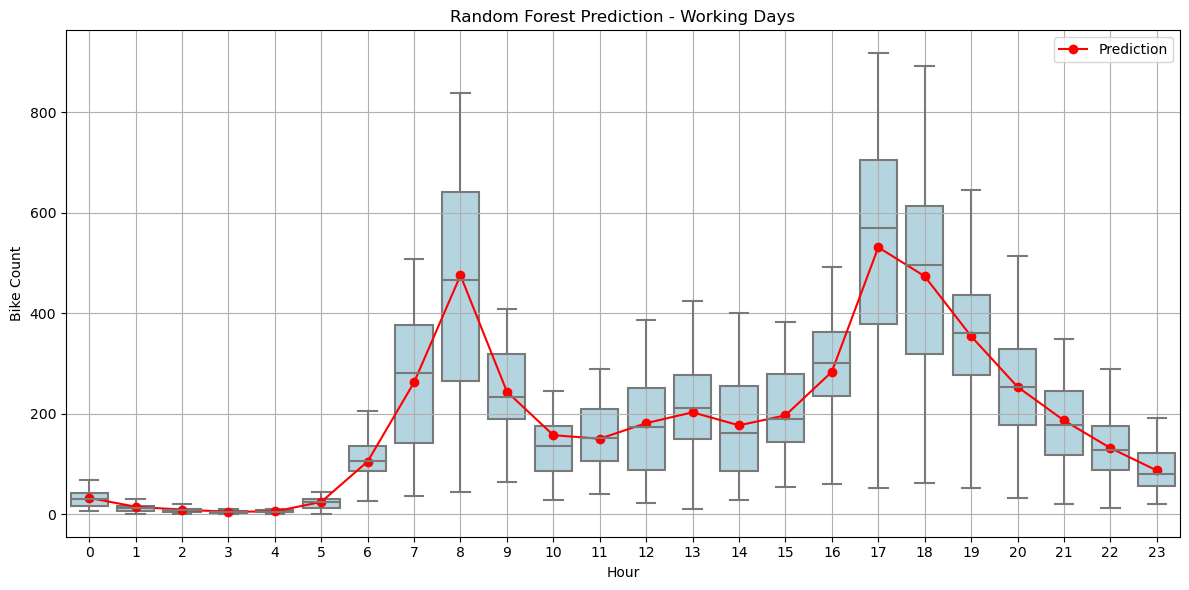


Random Forest parameters and RMSE for Working Days:
n_estimators: 100
max_depth: 10
min_samples_split: 2
min_samples_leaf: 1
RMSE: 57.06


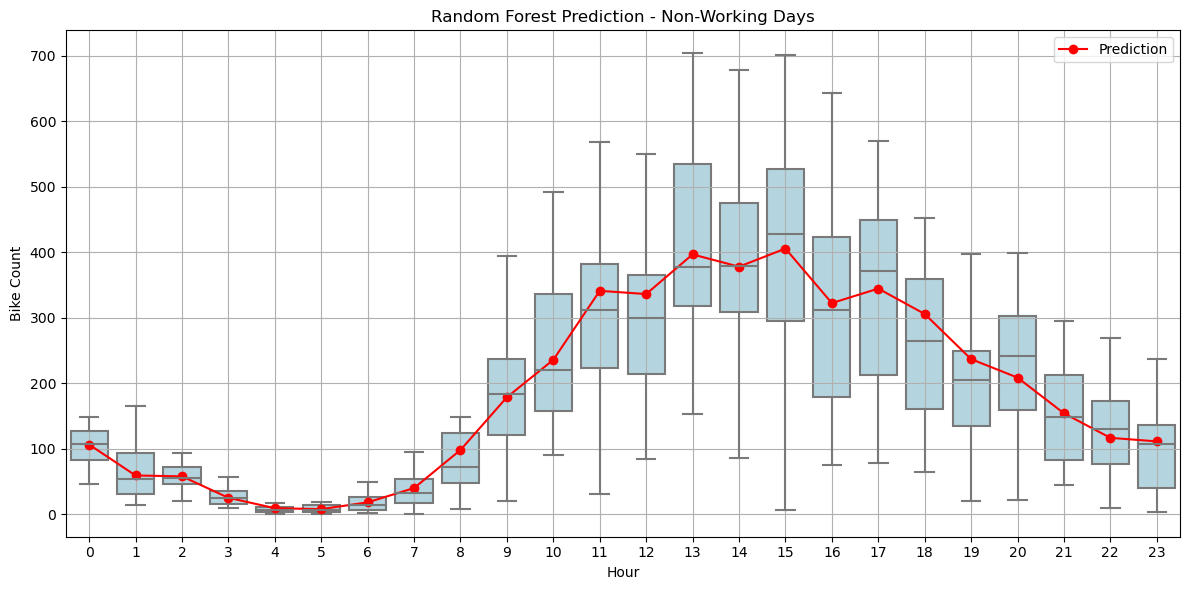


Random Forest parameters and RMSE for Non-Working Days:
n_estimators: 100
max_depth: 10
min_samples_split: 2
min_samples_leaf: 1
RMSE: 60.48


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def train_and_plot_rf(df_subset, label):
    """
    Trains a Random Forest on the given subset of data,
    makes predictions, computes RMSE, and plots results.

    Parameters:
    - df_subset: DataFrame filtered by workingday
    - label: string label for plotting and printouts
    """
    features = ["hour", "weekday", "month", "season", "year"]
    X = df_subset[features]
    y = df_subset["count"]

    # Split into train/test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Predict and calculate RMSE
    y_pred = rf.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    # Prepare DataFrame for plotting
    df_plot = X_test.copy()
    df_plot["hour"] = X_test["hour"]
    df_plot["y_true"] = y_test.values
    df_plot["y_pred"] = y_pred
    mean_pred_by_hour = df_plot.groupby("hour")["y_pred"].mean()

    # Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="hour", y="y_true", data=df_plot, color="lightblue", showfliers=False)
    plt.plot(mean_pred_by_hour.index, mean_pred_by_hour.values, color="red", marker="o", label="Prediction")
    plt.title(f"Random Forest Prediction - {label}")
    plt.xlabel("Hour")
    plt.ylabel("Bike Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print model info and RMSE
    rf_params = rf.get_params()
    rf_summary = {k: rf_params[k] for k in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']}
    rf_summary["RMSE"] = round(rmse, 2)

    print(f"\nRandom Forest parameters and RMSE for {label}:")
    for k, v in rf_summary.items():
        print(f"{k}: {v}")

# ⬇️ Apply the function to both working and non-working days
train_and_plot_rf(df[df["workingday"] == 1], "Working Days")
train_and_plot_rf(df[df["workingday"] == 0], "Non-Working Days")


✳️ Best model: RandomForest (CV‑RMSE = 125.052)
→ GridSearchCV best params: {'max_depth': None, 'n_estimators': 50}
RandomForest n_estimators: 50
RandomForest max_depth: None
RandomForest max_features: 1.0


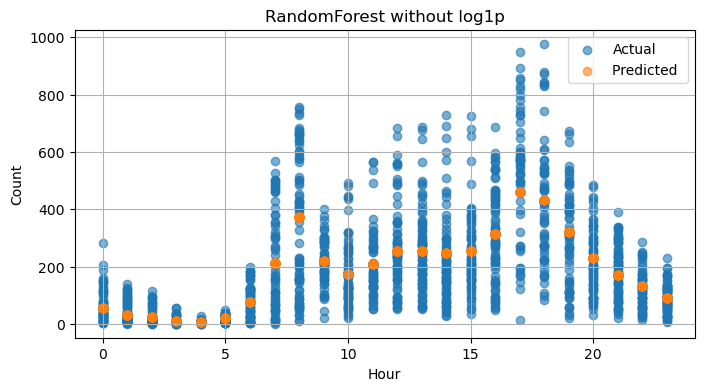

✳️ Best model: RandomForest (CV‑RMSE = 0.757)
→ GridSearchCV best params: {'max_depth': 10, 'n_estimators': 50}
RandomForest n_estimators: 50
RandomForest max_depth: 10
RandomForest max_features: 1.0


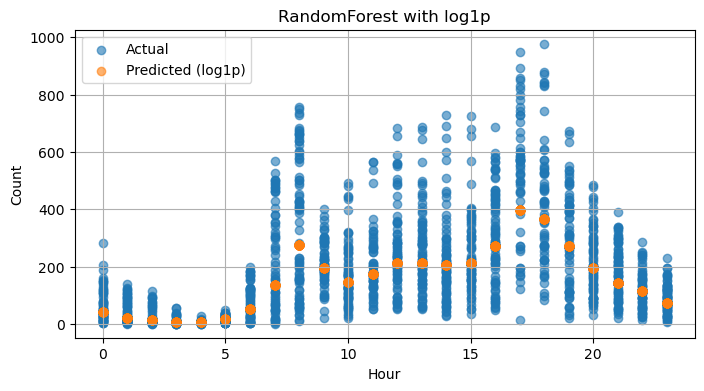

In [91]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

def fit_and_print_params(X_train, y_train, X_test, y_test, apply_log=False):
    """
    Fit models, print their parameters, and evaluate performance.

    Parameters:
    - X_train, y_train, X_test, y_test: dataset splits
    - apply_log (bool): whether to apply log1p on the target
    """
    # Trasforma il target se richiesto
    y_train_trans = np.log1p(y_train) if apply_log else y_train

    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "RandomForest": RandomForestRegressor(random_state=42)
    }

    # Valutazione via cross-validation
    cv_scores = {}
    for name, model in models.items():
        cv = np.sqrt(-cross_val_score(model, X_train, y_train_trans, cv=5, scoring='neg_mean_squared_error'))
        cv_scores[name] = cv.mean()

    # Seleziona il miglior modello
    best_name = min(cv_scores, key=cv_scores.get)
    best_model = models[best_name]
    print(f"✳️ Best model: {best_name} (CV‑RMSE = {cv_scores[best_name]:.3f})")

    # Hyper‑parameter tuning per RandomForest se è il migliore
    if best_name == "RandomForest":
        param_grid = {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}
        gs = GridSearchCV(best_model, param_grid, cv=3, scoring='neg_mean_squared_error')
        gs.fit(X_train, y_train_trans)
        best_model = gs.best_estimator_
        print("→ GridSearchCV best params:", gs.best_params_)

    # Fit finale sul train set
    best_model.fit(X_train, y_train_trans)

    # Stampa i parametri del modello
    if best_name in ["LinearRegression", "Ridge"]:
        print(f"Coefficients: {best_model.coef_}")
        print(f"Intercept: {best_model.intercept_:.3f}")
    else:  # RandomForest
        print(f"RandomForest n_estimators: {best_model.n_estimators}")
        print(f"RandomForest max_depth: {best_model.max_depth}")
        print(f"RandomForest max_features: {best_model.max_features}")
        # aggiungi altri parametri se desideri...

    # Predizioni e grafico
    y_pred = best_model.predict(X_test)
    if apply_log:
        y_pred = np.expm1(y_pred)

    plt.figure(figsize=(8, 4))
    plt.scatter(X_test['hour'], y_test, label='Actual', alpha=0.6)
    plt.scatter(X_test['hour'], y_pred, label=f'Predicted {"(log1p)" if apply_log else ""}', alpha=0.6)
    plt.title(f"{best_name} {'with' if apply_log else 'without'} log1p")
    plt.xlabel("Hour")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model

# Esempio d'uso:
model_no_log = fit_and_print_params(X_train, y_train, X_test, y_test, apply_log=False)
model_log    = fit_and_print_params(X_train, y_train, X_test, y_test, apply_log=True)
